In [1]:
from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn

In [2]:
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_class = 801
input_size = 224

In [3]:
model_test = EfficientNet.from_pretrained('efficientnet-b3')
num_ftrs = model_test._fc.in_features

model_test._fc  = nn.Linear(num_ftrs, num_class)

model_test.to(device)

model_test.load_state_dict(torch.load('./models/efficientnet-b3_epoch100.pth'))
model_test.eval()

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [4]:
from PIL import Image
from torchvision import datasets, transforms
import os

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

def inference_model(model, input_image_path):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        with Image.open(input_image_path) as input_image:
            resized_image = data_transforms['val'](input_image).unsqueeze(0).to(device)
            label = input_image_path.split('_')[-1].split('.')[0]
            
            output = model(resized_image)
            _, pred = torch.max(output, 1)
            
        model.train(mode=was_training)
    
    return class_names[pred[0]], label

Image 1
Predict: 團, Label: 田, Time elapsed: 0.050362348556518555



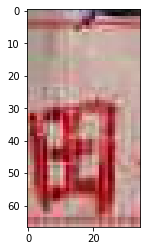

Image 2
Predict: 楊, Label: 千, Time elapsed: 0.02360224723815918



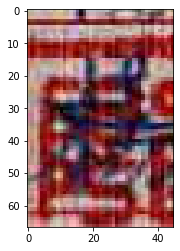

Image 3
Predict: 所, Label: 田, Time elapsed: 0.023458242416381836



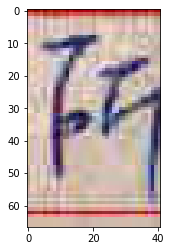

Image 4
Predict: 昇, Label: 昇, Time elapsed: 0.024558305740356445



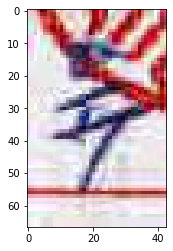

Image 5
Predict: isnull, Label: 主, Time elapsed: 0.02356719970703125



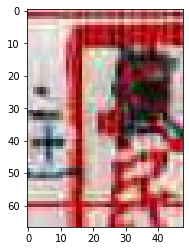

Inference Time: 0.1598968505859375


In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time

fig = plt.figure()

since = time.time()

words = ['2530_田.jpg', '22972_千.jpg', '35749_田.jpg', '38828_昇.jpg', '57332_主.jpg']

for i, word in enumerate(words):
    start = time.time()
    pred, label = inference_model(model_test, os.path.join('./data/all/', word))
    print(f'Image {i + 1}\nPredict: {pred}, Label: {label}, Time elapsed: {time.time() - start}\n')
    img = mpimg.imread(os.path.join('./data/all', word))
    plt.imshow(img)
    plt.pause(0.001)
    
time_elapsed = time.time() - since

print(f'Inference Time: {time_elapsed / len(words)}')

In [8]:
class_dict = {k: v for k, v in enumerate(class_names)}

In [9]:
import pickle

with open('idx2class.pickle', 'wb') as handle:
    pickle.dump(class_dict, handle)